# Aurora Express — Time Study Analysis (Project Velocity)

## Introduction

**Project:** Siemens Mobility – Project Velocity – Aurora Express Assembly Process  

**Objective:** Identify bottlenecks in the assembly process and propose targeted improvements to **not only meet but surpass efficiency and sustainability benchmarks**.  

**Dataset:** `Wheel_Assembly_Times.xlsx` — Recorded time study data for specific Aurora Express assembly steps. 

**Key Metrics:**  
- **Average (s)** — Mean completion time per step  
- **Standard Deviation (SD)** — Absolute variability per step  
- **Coefficient of Variation (CV)** — Relative variability (SD ÷ Average)

**Main Deliverables:**  
1. Visual overview of time distributions (Box Plot)  
2. Bottleneck identification based on **Average Time** and **CV** thresholds (mean + 2σ)  
3. Correlation analysis between Average Time and CV  
4. Findings and recommendations for efficiency improvement

---


## Load & Clean Data

This step imports the dataset, cleans the raw time study table, and computes key metrics:  
- Convert observed times from `mm:ss` format to seconds.  
- Calculate **Average (s)**, **Standard Deviation (SD)**, and **Coefficient of Variation (CV)** for each step.

In [2]:
# === Step 1: Load & Clean Data ===

import pandas as pd
import numpy as np

# File path
excel_path = "../data/Wheel_Assembly_Times.xlsx"

# Load the relevant sheet, skipping metadata rows
xls = pd.ExcelFile(excel_path)
df = xls.parse('Aurora Express Time Study', skiprows=5)

# Rename columns
df.columns = [
    "Step Number", "Step Description", "Time #1", "Time #2", "Time #3",
    "Time #4", "Time #5", "Time #6", "Time #7", "Time #8", "Time #9", "Time #10",
    "Average", "Range", "Notes"
]

# Drop any extra header row inside the data
df = df.drop(index=0).reset_index(drop=True)
df["Step Number"] = df["Step Number"].astype(int)

# Function to interpret hh:mm:ss as mm:ss
def parse_mmss(t):
    try:
        parts = str(t).split(":")
        if len(parts) == 3:
            minutes = int(parts[0])
            seconds = int(parts[1])
            return minutes * 60 + seconds
        elif len(parts) == 2:
            return int(parts[0]) * 60 + int(parts[1])
    except:
        return np.nan

# Convert observations to seconds
time_columns = [f"Time #{i}" for i in range(1, 11)]
for col in time_columns:
    df[col + " (s)"] = df[col].apply(parse_mmss)

# Convert Average to seconds
df["Average (s)"] = df["Average"].apply(parse_mmss)

# Compute Standard Deviation (SD) in seconds
obs_cols_sec = [col + " (s)" for col in time_columns]
df["SD (s)"] = df[obs_cols_sec].std(axis=1, ddof=1)

# Compute Coefficient of Variation (CV)
df["CV"] = df["SD (s)"] / df["Average (s)"]

# Final clean dataframe
df_clean = df[[
    "Step Number", "Step Description", "Average (s)", "SD (s)", "CV", "Notes"
]]

df_clean.head()

,Step Number,Step Description,Average (s),SD (s),CV,Notes
0,1,Retrieve wheel components from storage,147,5.797509,0.039439,Time varies by storage efficiency and distance.
1,2,Setup workspace and tools,98,6.419588,0.065506,Dependent on organization and availability of ...
2,3,Inspect components for defects,182,6.515793,0.035801,"Critical for quality, variability in defect ra..."
3,4,Assemble hub to wheel frame,256,8.121303,0.031724,"Precision task, requiring manual dexterity."
4,5,Secure hub with bolts,168,9.067647,0.053974,Utilizes specialized tools; time varies by too...


**📌 Interpretation:**  
- **Data is now in analysis-ready form**, with all time values in seconds.  
- **Average (s)** lets us compare step speeds directly.  
- **SD (s)** shows absolute variability in seconds.  
- **CV** captures relative variability (important for comparing short vs long steps). 

## Observed Times Pattern (Box Plot)

This step visualizes the distribution of observed times for each step using a **box plot**.  
- The box plot shows **median**, **interquartile range (IQR)**, and **outliers** for each step.  
- This provides a quick visual check for steps with unusually wide spreads or extreme observations.  
- The x-axis shows **step numbers** for clarity.

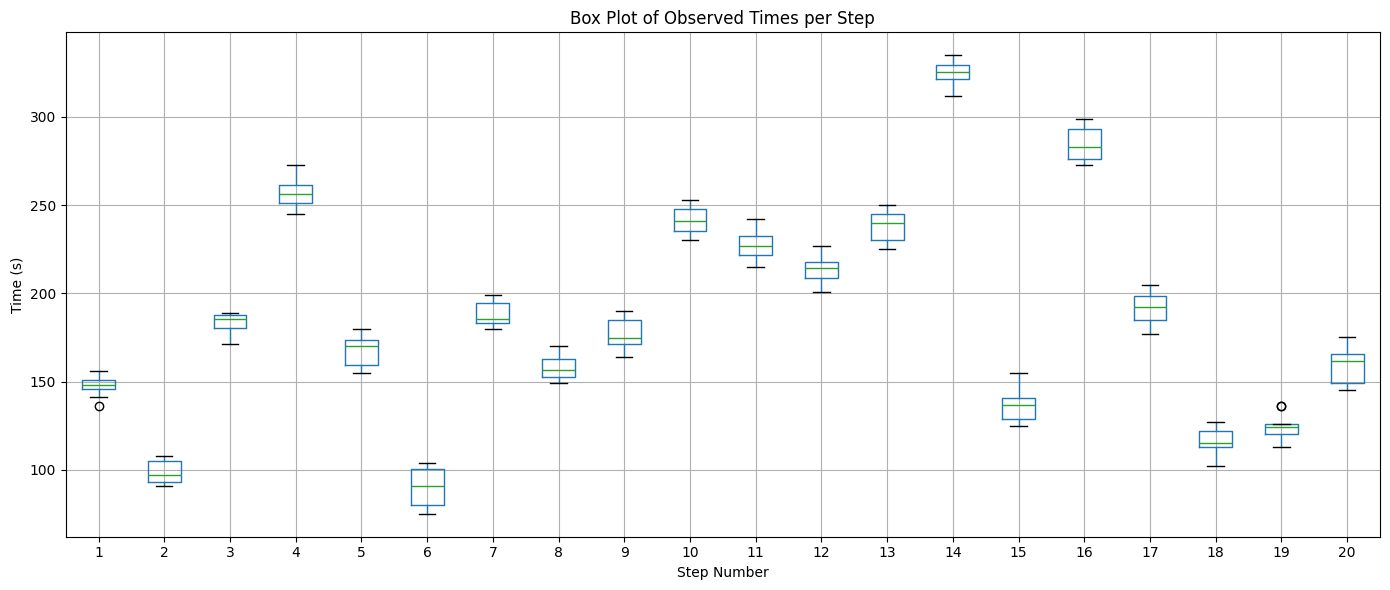

In [3]:
# === Step 2: Observed Times Pattern (Box Plot) ===

import matplotlib.pyplot as plt

# Prepare data for box plot (only observed times, not averages)
obs_cols_sec = [f"Time #{i} (s)" for i in range(1, 11)]
box_data = df[obs_cols_sec].transpose()
box_data.columns = df["Step Number"]

# Create box plot
plt.figure(figsize=(14, 6))
box_data.boxplot()
plt.title("Box Plot of Observed Times per Step")
plt.xlabel("Step Number")
plt.ylabel("Time (s)")
plt.xticks(ticks=df["Step Number"])  # Ensure whole numbers on x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

**📌 Interpretation:**  
- Most steps have relatively **tight IQRs**, indicating good consistency.  
- Steps with **taller boxes** or **numerous outliers** suggest greater variability or occasional delays.  
- In this dataset, **Step 6**, **Step 15**, and **Step 20** show wider spreads, indicating potential inconsistency.

## Bottlenecks (Average Time)

This step identifies steps with **significantly higher average times** using a strict threshold: 
$$
\text{Threshold} = \text{Mean Average Time} + 2 \times \text{Standard Deviation of Average Time}
$$ 
- Steps above this threshold are considered **critical time bottlenecks**.  
- The plot shows each step’s average time in seconds, with a dashed red line marking the threshold.  
- Steps above the line are labeled for clarity.


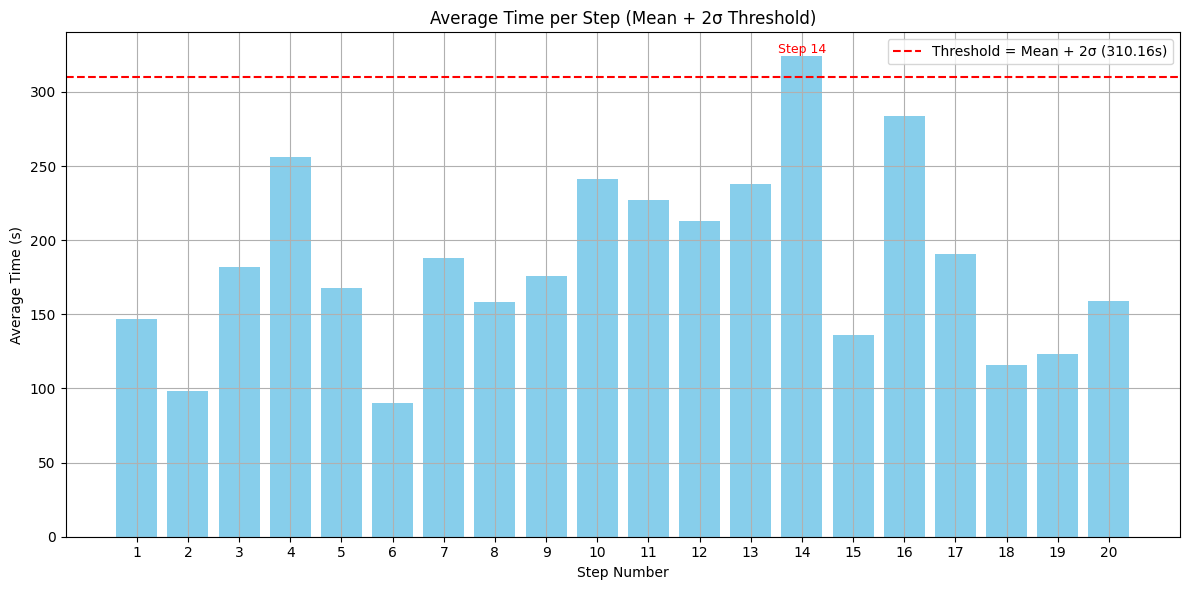

,Step Number,Step Description,Average (s),Notes
13,14,Mount wheel to axle,324,"Heaviest component, requires crane; timing var..."


In [4]:
# === Step 3: Bottlenecks — Average Time (Mean + 2σ) ===

# Calculate threshold
avg_time_threshold_2std = df["Average (s)"].mean() + 2 * df["Average (s)"].std()

# Filter steps exceeding threshold
critical_avg_steps = df[df["Average (s)"] > avg_time_threshold_2std][
    ["Step Number", "Step Description", "Average (s)", "Notes"]
]

# Plot
plt.figure(figsize=(12, 6))
plt.bar(df["Step Number"], df["Average (s)"], color="skyblue")
plt.axhline(avg_time_threshold_2std, color="red", linestyle="--",
            label=f"Threshold = Mean + 2σ ({avg_time_threshold_2std:.2f}s)")

# Annotate steps above threshold
for i, row in df.iterrows():
    if row["Average (s)"] > avg_time_threshold_2std:
        plt.annotate(f"Step {row['Step Number']}", 
                     (row["Step Number"], row["Average (s)"] + 2),
                     ha="center", fontsize=9, color="red")

plt.title("Average Time per Step (Mean + 2σ Threshold)")
plt.xlabel("Step Number")
plt.ylabel("Average Time (s)")
plt.xticks(ticks=df["Step Number"])  # Whole numbers
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display table of critical steps
critical_avg_steps

**📌 Interpretation:**  
- Only **Step 14: Mount wheel to axle** exceeds the strict **Mean + 2σ** threshold.  
- This indicates Step 14 is the **primary time bottleneck** in the assembly process.  
- Notes indicate the delay is likely due to **equipment dependency** (crane usage) and the complexity of aligning heavy components.  
- Addressing this step has the highest potential to **reduce overall cycle time**.

## Bottlenecks (CV)

This step identifies steps with **significantly higher relative variability** using the **Coefficient of Variation (CV)**.  
- CV is calculated as:
$$
\text{CV} = \frac{\text{Standard Deviation (s)}}{\text{Average Time (s)}}
$$  
- The threshold is set to:
$$
\text{Threshold} = \text{Mean CV} + 2 \times \text{Standard Deviation of CV}
$$  
- Steps above this threshold are considered **critical variability bottlenecks**.  
- This method normalizes variability across steps of different durations, making comparisons fair.

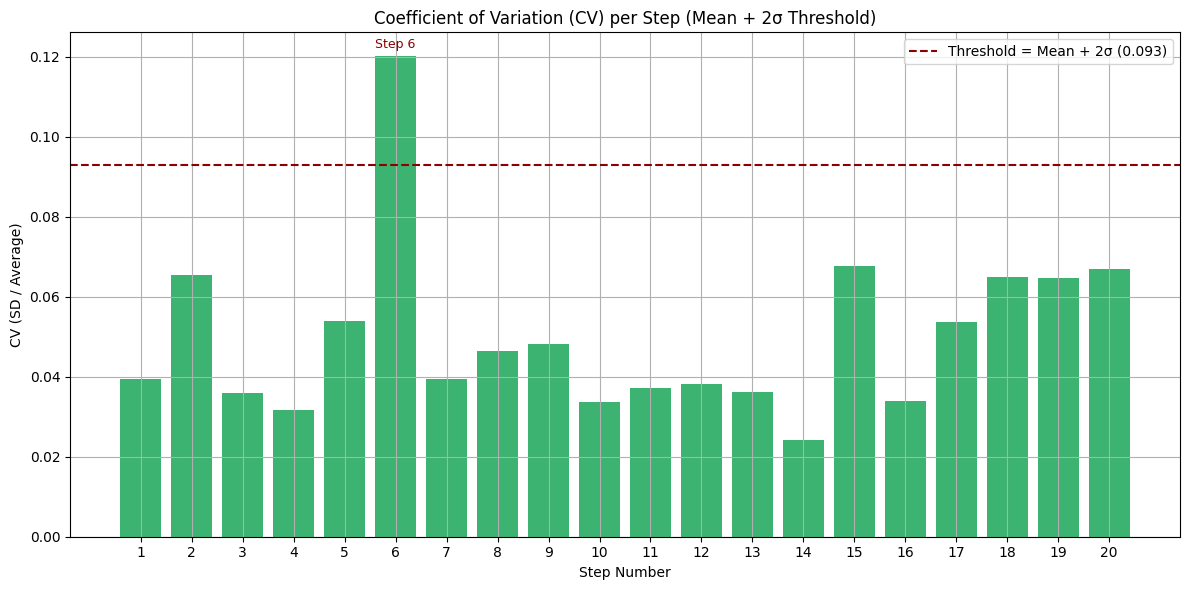

,Step Number,Step Description,Average (s),SD (s),CV,Notes
5,6,Lubricate wheel bearings,90,10.805863,0.120065,"Standardized process, but slight variations in..."


In [5]:
# === Step 4: Bottlenecks — CV (Mean + 2σ) ===

# Calculate CV threshold
cv_threshold_2std = df["CV"].mean() + 2 * df["CV"].std()

# Filter steps exceeding threshold
critical_cv_steps = df[df["CV"] > cv_threshold_2std][
    ["Step Number", "Step Description", "Average (s)", "SD (s)", "CV", "Notes"]
]

# Plot CV per step
plt.figure(figsize=(12, 6))
plt.bar(df["Step Number"], df["CV"], color="mediumseagreen")
plt.axhline(cv_threshold_2std, color="darkred", linestyle="--",
            label=f"Threshold = Mean + 2σ ({cv_threshold_2std:.3f})")

# Annotate steps above threshold
for i, row in df.iterrows():
    if row["CV"] > cv_threshold_2std:
        plt.annotate(f"Step {row['Step Number']}", 
                     (row["Step Number"], row["CV"] + 0.002),
                     ha="center", fontsize=9, color="darkred")

plt.title("Coefficient of Variation (CV) per Step (Mean + 2σ Threshold)")
plt.xlabel("Step Number")
plt.ylabel("CV (SD / Average)")
plt.xticks(ticks=df["Step Number"])  # Whole numbers
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Display table of critical CV steps
critical_cv_steps

**📌 Interpretation:**  
- Only **Step 6: Lubricate wheel bearings** exceeds the strict **Mean + 2σ** threshold for CV.  
- This indicates **high relative variability** compared to other steps, even though it is a short-duration task.  
- The high CV suggests **operator technique differences**, **tool accessibility issues**, or inconsistent process definition.  
- Standardizing lubrication method and improving tool placement could significantly reduce variability.

## Correlation Analysis (Average Time vs CV)

This step checks for a statistical relationship between **average step duration** and **relative variability (CV)**.  
- Uses **Pearson correlation coefficient**:
$$
r = \frac{\text{cov}(X, Y)}{\sigma_X \sigma_Y}
$$
where \( X \) = Average Time, \( Y \) = CV.  
- A positive \( r \) indicates longer steps tend to have higher variability;  
  a negative \( r \) means longer steps tend to be more consistent.

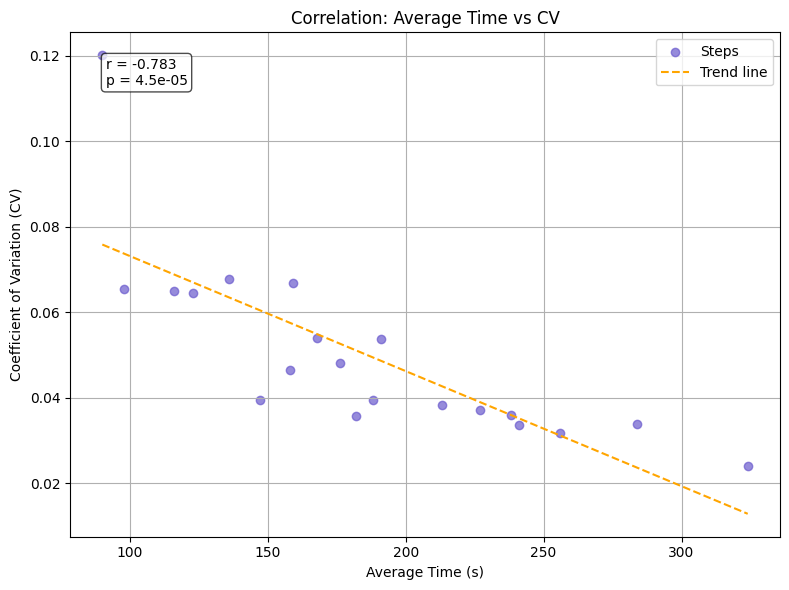

(np.float64(-0.7828017845734266), np.float64(4.501896780215373e-05))

In [6]:
# === Step 5: Correlation Analysis — Average Time vs CV (Updated Plot with Actual Results) ===
from scipy.stats import pearsonr, linregress
import matplotlib.pyplot as plt
import numpy as np

# Calculate Pearson correlation
r_value, p_value = pearsonr(df["Average (s)"], df["CV"])

# Fit a trend line
slope, intercept, _, _, _ = linregress(df["Average (s)"], df["CV"])
trend_x = np.linspace(df["Average (s)"].min(), df["Average (s)"].max(), 100)
trend_y = slope * trend_x + intercept

# Scatter plot with trend line
plt.figure(figsize=(8, 6))
plt.scatter(df["Average (s)"], df["CV"], color="slateblue", alpha=0.7, label="Steps")
plt.plot(trend_x, trend_y, color="orange", linestyle="--", label="Trend line")

# Annotate r and p values
plt.text(0.05, 0.95, f"r = {r_value:.3f}\np = {p_value:.1e}",
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.title("Correlation: Average Time vs CV")
plt.xlabel("Average Time (s)")
plt.ylabel("Coefficient of Variation (CV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Output correlation results
r_value, p_value

**📌 Interpretation:**  
- The Pearson \( r = -0.783 \) indicates a **strong negative correlation** — longer steps tend to have **lower relative variability (CV)**.  
- The very low p-value $p \approx 4.50 \times 10^{-5}$ means this relationship is **highly statistically significant**.
- In practice:  
  - Longer tasks are likely **well-standardized** (e.g., formal procedures, specialized equipment).  
  - Shorter tasks may depend more on **operator technique or manual handling**, leading to higher variability.  
- This insight suggests that **variability reduction efforts** should focus more on **short-duration tasks**, which are proportionally less consistent.

## Findings & Recommendations

This section summarizes the key results from the bottleneck and variability analysis,  
and provides targeted recommendations to improve efficiency and reduce variability.

### Key Findings
1. **Primary Time Bottleneck (Average Time, Mean + 2σ):**
   - **Step 14: Mount wheel to axle** — Average time 324s, far above threshold.
   - Cause (from notes): Heavy component requiring crane, delays from equipment availability.

2. **Primary Variability Bottleneck (CV, Mean + 2σ):**
   - **Step 6: Lubricate wheel bearings** — CV = 0.120, well above variability threshold.
   - Cause (from notes): Variations in lubrication method and accessibility.

3. **Correlation Insight:**
   - Strong negative correlation ($r = -0.783$, $p \approx 4.50 \times 10^{-5}$)  
     → Longer steps tend to have **lower** relative variability.
   - Shorter steps have proportionally more fluctuation, suggesting reliance on operator skill.

---

### Recommendations
**Step 14 — Mount wheel to axle (Priority #1)**
- **Proposed Intervention:** Introduce an **automated wheel-mounting system** to reduce manual alignment and crane dependency.
- **Expected Impact:** Reduce cycle time for the longest step, improve equipment utilization, and reduce delays cascading to downstream steps.

**Step 6 — Lubricate wheel bearings (Priority #2)**
- **Proposed Intervention:** Standardize lubrication method and tool placement.
- **Expected Impact:** Reduce relative variability (CV) without significantly affecting mean duration, improving overall process consistency.

---

### Implementation Priority Rationale
- Improving **Step 14** first addresses the **largest time bottleneck**, providing the greatest direct reduction in total assembly time.
- Improvements in **Step 6** should follow, targeting variability reduction in short tasks to improve process stability.

---

**Overall Conclusion:**
- Targeting **Step 14** first aligns with the goal to surpass efficiency benchmarks by removing the largest single delay.  
- Focusing on **Step 6** next will improve sustainability through reduced variability, supporting consistent long-term performance.